### Sparcle on pciSeq/ISS

#### 16th May 2021
#### Code author SP

#### In this example we use the data present at:https://colab.research.google.com/github/acycliq/pciSeq/blob/master/notebooks/pciSeq.ipynb to create data structures necessary for Sparcle. These additional data are provided in the pciSeq_ISS folder.

#### Save these files to the same location where this github code resides on your local machine

In [149]:
import os
import sys

import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import time

from matplotlib.patches import Polygon

from PIL import Image, ImageDraw
from skimage import measure #package is scikit-image

import pandas as pd


import matplotlib.pyplot as plt
plt.close('all')

from scipy.spatial import distance

import phenograph as pg
import cv2

from sklearn.mixture import BayesianGaussianMixture
from sklearn.manifold import TSNE

#import matplotlib
#matplotlib.use('Agg')

import random
from scipy.stats import zscore

import scipy.stats as stats
from scipy.stats import multivariate_normal

from joblib import Parallel, delayed
import multiprocessing

import scipy.io
from scipy.io import mmread

import colorsys

import seaborn as sns
import fastcluster


from scipy.spatial import distance

from numpy.lib.stride_tricks import as_strided

import tifffile


from matplotlib import colors as mcolors

from scipy.spatial import ConvexHull


from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [150]:
import os
import numpy as np
import pandas as pd
import skimage.color
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from scipy.sparse import coo_matrix
#import pciSeq
#from pciSeq import utils

In [151]:
path_data = os.getcwd() # or desired location to where the pciSeq_ISS folder is saved to 

colours_30 = ["firebrick","gold","royalblue","green","dimgray","orchid","darkviolet",
              "red", "orange", "limegreen", "blue", "purple", "seagreen","gold","darkolivegreen",
              "lightpink","thistle","mistyrose","saddlebrown","slategrey","powderblue",
            "palevioletred","mediumvioletred","yellowgreen","lemonchiffon","chocolate",
              "lightsalmon","lightcyan","lightblue", "darkorange","yellow","violet","black","mediumslateblue","magenta"]

In [153]:


def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-',linewidth=0.5)


colours=[ "darkviolet", "red", "orange", "limegreen", "blue", "purple", "seagreen","gold","lightpink","thistle","mistyrose","saddlebrown","slategrey",
            "palevioletred","mediumvioletred","yellowgreen","darkolivegreen","lemonchiffon","chocolate","lightsalmon","lightcyan","lightblue", "black"]


def setdiff2d(lst1,lst2):
    aset = set([tuple(x) for x in lst1])
    bset = set([tuple(x) for x in lst2])
    l = np.array([x for x in aset - bset])
    return l

def is_nan(x):
    return (x is np.nan or x != x)


def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        r_c = np.random.rand()
        hue = i/360.
        lightness = (50 + r_c * 10)/100.
        saturation = (90 + r_c * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

#set clustering algorithm choice
bayes_MM = 0 # to run the DPMM else set to 0 for phenograph

num_comp = 10

neigh_size = 100#15

dist_ub =  250


dpi_set = 100

num_pg_k = 50

num_fov = 1


mRNA_asgn_counter = np.zeros([num_fov,1])

s_size = 20

#num_colour = 50
win_size =  150


#cm = plt.cm.get_cmap('tab20',num_colour)
#cm = get_colors(num_colour)
cm = colours

f_size=10

fig2p = 0

z = 2

num_cell_fov = np.zeros(num_fov, dtype=int)

asgn_stats_list=[] 
asgn_stats_listoflists = [] 

mRNA_assign_listoflists = [] 
iterations = 1
num_cores = multiprocessing.cpu_count() - 1
inputs = range(num_fov)

Merfish_genes = 140

givens = False
wgt_mock_cell = False

In [154]:
#colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = dict(mcolors.BASE_COLORS, **mcolors.XKCD_COLORS)

#https://matplotlib.org/examples/color/named_colors.html
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]
len(sorted_names)
len(colors)

957

In [ ]:
### read in the data

incell_mrna = np.array(pd.read_csv(os.path.join(path_data+'incell_mrna_list_pciseq.csv'), float_precision=None,header=None, index_col=None).as_matrix())

dmrna_need = np.array(pd.read_csv(os.path.join(path_data+'to_plot_dmrna_pciseq.csv'),float_precision=None, header=None, index_col=None).as_matrix())

pciseq_CM = np.array(pd.read_csv(os.path.join(path_data+'pciseq_CM.csv'), float_precision=None,header=None, index_col=None).as_matrix())
cell_centroids = np.array(pd.read_csv(os.path.join(path_data+'pciSeq_centroids.csv'), float_precision=None,header=None, index_col=None).as_matrix())

iss_spots = np.array(pd.read_csv(os.path.join(path_data+'pciseq_iss_spots.csv'), float_precision=None,header=0, index_col=None).as_matrix())
#gene, x, y

# no 'blank' genes
unique_pciseq_genes = np.array(pd.read_csv(os.path.join(path_data+'unique_pciseq_genes.csv'), float_precision=None,header=None, index_col=None).as_matrix())

In [157]:
# spots

iss_spots.shape

(72336, 3)

In [158]:
dmrna_need.shape

(10078, 1)

In [159]:
incell_mrna.shape

(62258, 1)

In [161]:
cell_centroids_1 = np.transpose(cell_centroids)

In [162]:
cell_centroids_1.shape

(2, 2010)

### run Sparcle

In [163]:
num_cells = pciseq_CM.shape[0]
num_genes = pciseq_CM.shape[1]

In [164]:
tsne = TSNE(n_components=2, verbose=1)#, perplexity=30, n_iter=900)
X_2d = tsne.fit_transform(pciseq_CM)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2010 samples in 0.000s...
[t-SNE] Computed neighbors for 2010 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2010
[t-SNE] Computed conditional probabilities for sample 2000 / 2010
[t-SNE] Computed conditional probabilities for sample 2010 / 2010
[t-SNE] Mean sigma: 1.816431
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.979927
[t-SNE] KL divergence after 1000 iterations: 1.139003


In [165]:
num_comp = 14
M = np.log(pciseq_CM+0.1)

Mod_dpgmm_bysr=BayesianGaussianMixture(n_components=num_comp, covariance_type='full',
                                  weight_concentration_prior_type='dirichlet_process').fit(M)
cluster_asgn = np.array(Mod_dpgmm_bysr.predict(M))


In [ ]:
df_data = pd.DataFrame(cluster_asgn)
df_data.to_csv(os.path.join(path_data+'cell_clusters.csv'), header=None, index=None)

df_data = pd.DataFrame(X_2d)
df_data.to_csv(os.path.join(path_data + 'X_2d.csv'), header=None, index=None)

In [ ]:
unique, counts = np.unique(cluster_asgn, return_counts=True)


In [ ]:
## build the cluster moments

mean_mat_it = [] #1 x genes per entry. K x genes overall
cov_list_it = [] # genes x genes per entry. K genes x genes overall
joint_mat_it = [] # samples X genes per entry. K samples x genes overall

pciseq_CM_zs = np.log(pciseq_CM+0.1)#,axis=1)
pciseq_CM_copy = np.copy(pciseq_CM)

for i in range(len(unique)): #target_ids:
    print(i)
     
    rows = np.where(cluster_asgn==unique[i]) #np.where(cluster_asgn==unique[i])
    rows = np.array(rows).flatten()


    if (rows.shape[0] > 1):
        print(i)
        mean_mat_it.append(np.mean(pciseq_CM_zs[rows, 0:num_genes], axis=0))
        cov_mat = np.cov(pciseq_CM_zs[rows, 0:num_genes].T)
        cov_mat = np.dot(cov_mat,cov_mat.T)
        np.fill_diagonal(cov_mat, np.diag(cov_mat)+1)
        cov_list_it.append(cov_mat)

    else:
        print('ee',i)
        mean_mat_it.append(np.mean(pciseq_CM_zs[rows,0:num_genes]))
        cov_list_it.append(np.var(pciseq_CM_zs[rows, 0:num_genes]))


In [169]:
pciseq_CM_postSpar = np.copy(pciseq_CM_zs)# 

l2_norm_mat = np.zeros([num_cells, dmrna_need.shape[0]],dtype=float) #2024 x 10078

dmrna_to_cell_map = np.zeros([dmrna_need.shape[0],2],dtype=float)  

closest_cells = []

assign_yn = np.zeros(dmrna_need.shape[0])

cluster_asgn_pciseq_it = np.copy(cluster_asgn)
c_x = np.unique(cluster_asgn_pciseq_it, return_inverse=True)
c_xx = np.array(c_x)[1]
unique_pciseq_it = np.copy(unique) 

In [170]:
iss_spots.shape

(72336, 3)

In [171]:
dmrna_need.shape

(10078, 1)

In [ ]:
################################
## Iteration 0 #################
################################

bin_1 = 0



for it in range(iterations):
    #plt.figure(figsize=(8,8),frameon=False,dpi=dpi_set)
    plt.figure(figsize=(20,20),frameon=False,dpi=dpi_set)
    plt.scatter(cell_centroids_1[1,:],cell_centroids_1[0,:],color='r',s=2)
    plt.scatter(iss_spots[dmrna_need,1], iss_spots[dmrna_need,2], s=1,c='blue')
    print('iter')
    print(it)
    mRNA_asgn_counter = 0
    for l in range(dmrna_need.shape[0]):
        # mock cell creation
        # print("create mock cell")
        # print("l is ", str(l))
        #p = np.array(np.where(asgn_mRNA[l]==mRNA_all_list[f])).flatten()
        print(l)
        if (assign_yn[l]==0):
            xc = iss_spots[dmrna_need[l],1]  
       	    yc = iss_spots[dmrna_need[l],2]  
            l_xc = xc - win_size
            r_xc = xc + win_size
            l_yc = yc - win_size
            u_yc = yc + win_size
            # finding its nearest cells
            for g in range(num_cells):            
                l2_norm_mat[g,l] = distance.euclidean([xc,yc], [cell_centroids_1[1,g],cell_centroids_1[0,g]])
            
            closest_cells.append(np.argsort(l2_norm_mat[:,l])[np.where((np.sort(l2_norm_mat[:,l])[0:neigh_size]<dist_ub)==True)])
       
            #print("build the mock cell")
            #for the circle
            ind = np.where(pow(iss_spots[:,1] -xc,2) + pow(iss_spots[:,2] -yc,2) <= pow(win_size,2))
            ind = np.array(ind).flatten()
            num_mRNA_neighs = ind.shape[0]
            mock_cell = np.zeros((1,num_genes))  #note change
 
            for k in range(num_mRNA_neighs):

            
                bc_id = np.array(np.where(iss_spots[ind[k],0] == unique_pciseq_genes)).flatten()[0]
                #print(bc_id)
                mock_cell[0,int(bc_id)] = mock_cell[0,int(bc_id)]  +  1
       
            mle_mockcell = np.zeros((1,len(unique_pciseq_it)))

            for u in range(len(unique_pciseq_it)):
                mle_mockcell[0,u] = multivariate_normal.logpdf(zscore(mock_cell,axis=1), mean_mat_it[u], cov_list_it[u])
        
            mle_k = np.argmax(mle_mockcell)       
            #assign to closest cell of that ML cluster

            cc = np.array(closest_cells[l]).flatten()
            mle_cc = np.array(np.where(c_xx[cc]==mle_k)).flatten()
        
            #plot this line from mRNA to assign to cell 
            if (len(mle_cc)!=0): 
                #means there are cells in the neighbourhood of mRNA that are of the same class
                cell_to_map = cc[mle_cc[0]]
                x_temp = [cell_centroids_1[1,cell_to_map],xc]
                y_temp = [cell_centroids_1[0,cell_to_map],yc]
 
                mRNA_asgn_counter = mRNA_asgn_counter + 1
                plt.plot(x_temp, y_temp, linewidth=0.5,c=cm[int(np.array(np.where(unique_pciseq_it==cluster_asgn_pciseq_it[cell_to_map])).flatten())])
                #plt.plot(x_temp, y_temp, linewidth=0.5, c='red')
            
                gene_1 = np.array(np.where(iss_spots[dmrna_need[l]] == unique_pciseq_genes)).flatten()[0]
            
                pciseq_CM_copy[cell_to_map, int(gene_1)] = pciseq_CM_copy[cell_to_map,int(gene_1) ] + 1

                plt.plot(xc, yc,'+',markersize=2, c=sorted_names[np.int(gene_1)])
                #print(cluster_asgn_pciseq_it[cell_to_map])
                #print('###')
                #print(cell_to_map)
                assign_yn[l]=1
                dmrna_to_cell_map[l,0]=dmrna_need[l]# use this in transcripts_75_gene directly
                dmrna_to_cell_map[l,1]=cell_to_map

        #else:
        #    plt.plot(xc,yc, '.', markersize=1, c='black')#, alpha=0.5)


    print('mRNA_asgn_counter:')
    print(mRNA_asgn_counter)

df_data = pd.DataFrame(pciseq_CM_postSpar)
df_data.to_csv(os.path.join(path_data + '/count_matrix_PostSparcle_pciseq_iter.csv'), header=None, index=None)



df_data = pd.DataFrame(dmrna_to_cell_map)
df_data.to_csv(os.path.join(path_data + '/dmrna_to_cell_map_PostSparcle_pciseq_'+str(bin_1)+'.csv'), header=None, index=None)

df_data = pd.DataFrame(assign_yn)
df_data.to_csv(os.path.join(path_data + '/assign_yn_PostSparcle_pciseq_'+str(bin_1)+'.csv'), header=None, index=None)

df_data = pd.DataFrame(pciseq_CM_copy)
df_data.to_csv(os.path.join(path_data + '/pciseq_CM_copy_PostSparcle_vz_'+str(bin_1)+'.csv'), header=None, index=None)


plt.savefig(os.path.join(path_data+'figures_python/pciseq_'+str(bin_1)+'.png'),dpi=300)

In [206]:
# number of dmrna assigned
mRNA_asgn_counter

6998

In [212]:
# % of mRNA assigned
print(mRNA_asgn_counter*100/dmrna_need.shape[0])

69.43838063107759


In [ ]:
pciseq_CM_postSpar = np.log(pciseq_CM_copy+0.1) #zscore(pciseq_CM_postSpar,axis=1)


num_comp = 14

Mod_dpgmm=BayesianGaussianMixture(n_components=num_comp, covariance_type='full',
                                  weight_concentration_prior_type='dirichlet_process').fit(pciseq_CM_postSpar)
cluster_asgn_pciseq_it = np.array(Mod_dpgmm.predict(pciseq_CM_postSpar))



unique_pciseq_it, counts_pciseq_it = np.unique(cluster_asgn_pciseq_it, return_counts=True)

num_colour = 20
cm1 = plt.cm.get_cmap('tab20', num_colour)

c_x = np.unique(cluster_asgn_pciseq_it, return_inverse=True)
c_xx = np.array(c_x)[1]


##update the clusters based on new count matrix


mean_mat_it = [] #1 x genes per entry. K x genes overall
cov_list_it = [] # genes x genes per entry. K genes x genes overall
joint_mat_it = [] # samples X genes per entry. K samples x genes overall
U_mat_it = [] # same

for i in range(len(unique_pciseq_it)): #target_ids:
    #print(i)
    rows = np.where(cluster_asgn_pciseq_it==i) #np.where(cluster_asgn==unique[i])
    rows = np.array(rows).flatten()


    if (rows.shape[0] > 1):
        print(i)
        mean_mat_it.append(np.mean(pciseq_CM_postSpar[rows, 0:num_genes], axis=0))
        cov_mat = np.cov(pciseq_CM_postSpar[rows, 0:num_genes].T)
        cov_mat = np.dot(cov_mat,cov_mat.T)
        np.fill_diagonal(cov_mat, np.diag(cov_mat)+1)
        cov_list_it.append(cov_mat)

    else:
        print('ee',i)
        mean_mat_it.append(np.mean(pciseq_CM_postSpar[rows,0:num_genes]))
        cov_list_it.append(np.var(pciseq_CM_postSpar[rows, 0:num_genes]))

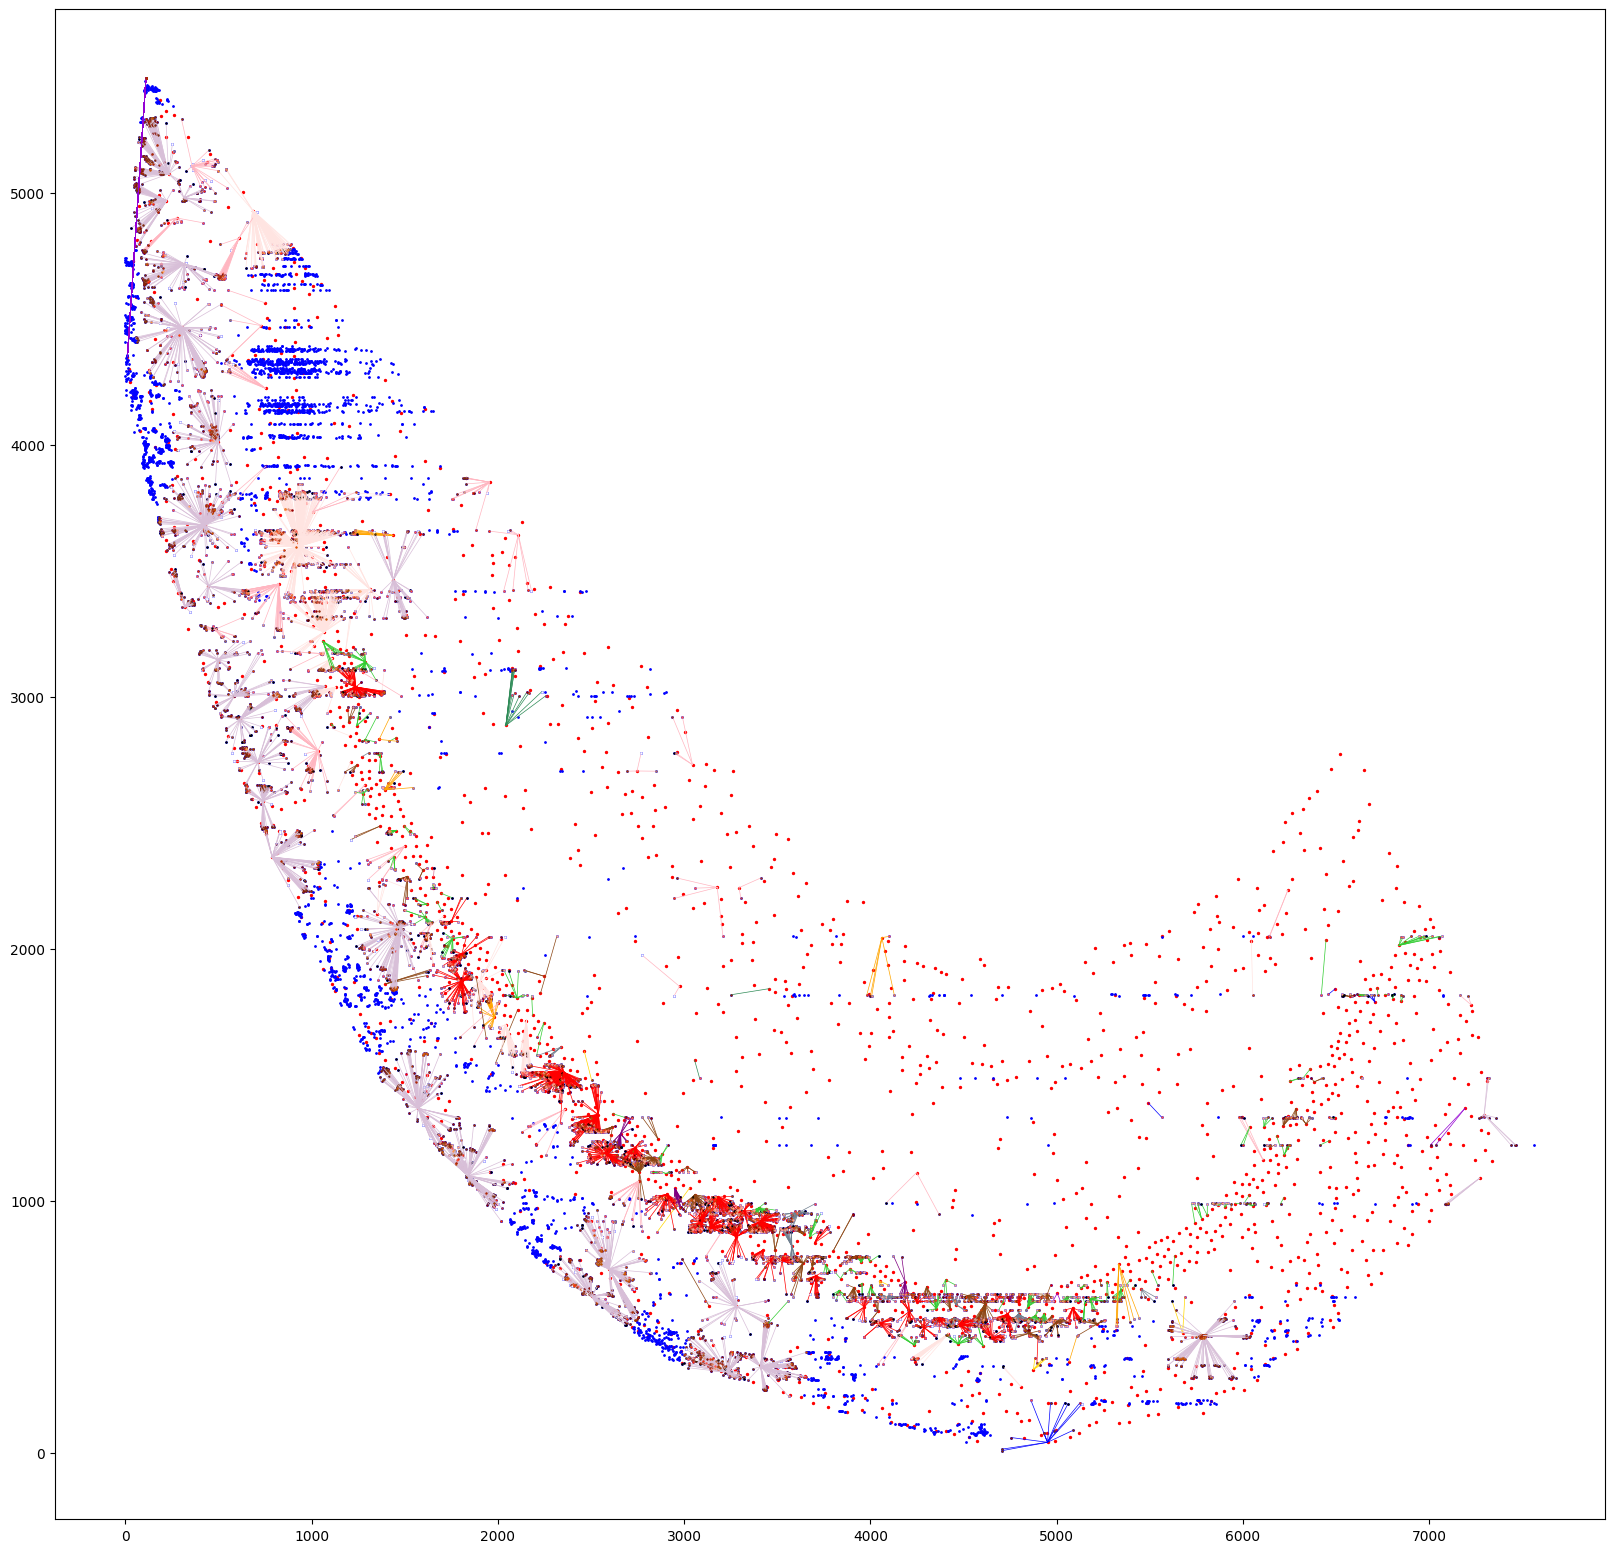

In [218]:
## plot in the end
## cell centroids: red dots
## assigned dangling mRNAs: coloured '+' where each colour is a gene
## unassigned dangling mRNAs: blue dots
## lines are drawn between a cell centroid and assigned mRNAs, where the line is coloured based on the current cluster of the cell


plt.figure(figsize=(20,20),frameon=False,dpi=dpi_set)
plt.scatter(cell_centroids_1[1,:],cell_centroids_1[0,:],color='r',s=2)
plt.scatter(iss_spots[dmrna_need,1], iss_spots[dmrna_need,2], s=1,c='blue')

for l in range(dmrna_need.shape[0]):
    xc = iss_spots[int(dmrna_to_cell_map[l,0]),1]
    yc = iss_spots[int(dmrna_to_cell_map[l,0]),2]
    #xc = dmrna_xy[l,0]  
    #yc = dmrna_xy[l,1]  
    cell_to_map = int(dmrna_to_cell_map[l,1])
    x_temp = [cell_centroids[cell_to_map,1],xc]
    y_temp = [cell_centroids[cell_to_map,0],yc]
    plt.plot(x_temp, y_temp, linewidth=0.5,c=cm[int(np.array(np.where(unique_pciseq_it==cluster_asgn_pciseq_it[cell_to_map])).flatten())])

    gene_1 = np.array(np.where(iss_spots[dmrna_need[l]] == unique_pciseq_genes)).flatten()[0]
    plt.plot(xc, yc,'+',markersize=2, c=sorted_names[np.int(gene_1)])

#plt.savefig(os.path.join(path_data+'/figures_python/pciseq_all.png'),dpi=300)


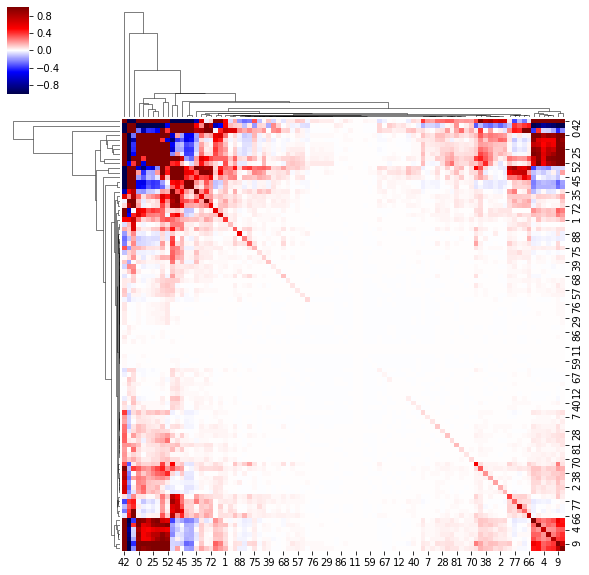

In [188]:
## Clustermap of postSparcle count matrix
sns.clustermap(np.cov(np.transpose(pciseq_CM_copy)),cmap='seismic',vmin=-1,vmax=1)

In [189]:
np.sum(pciseq_CM_copy)

62166.0

In [190]:
np.sum(pciseq_CM)

55168.0